#### Deployment to Production Data:

This notebook aims to simulate the deplyoment of the XGB model built to production data. Please note that the dataset is an unseen test set provided by the data masters. 

In [5]:
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [6]:

def load_data(path):
    """
    Load the data and drop Unnamed column.
    
    Parameters:
    path where the data is stored.
    
    Returns:
    Dataframe.
    """
    try:
        data = pd.read_csv(path)
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# load pkl files for model, imputer, scaler  
def load_assets(model_path, imputer_path, scaler_path):
    """
    Load the model, imputer, and scaler from disk.
    """
    model = joblib.load(model_path)
    imputer = joblib.load(imputer_path)
    scaler = joblib.load(scaler_path)
    return model, imputer, scaler

def clean_data(df):
    """
    Function to clean data by handling missing values and anomalies.
    """
    # renaming columns
    df = df.rename(columns={'credit_limit_used(%)': 'credit_limit_used_pctg'})
    # Filling missing values for 'no_of_children', 'owns_car', 'migrant_worker', 'total_family_members' with mode
    for col in ['no_of_children', 'owns_car', 'migrant_worker', 'total_family_members']:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Handling 'XNA' values in 'gender'
    df['gender'] = df['gender'].replace('XNA', df['gender'].mode()[0])

    # Your data might have specific anomalies that you discovered during EDA.
    # Include code to handle those anomalies here.
    
    return df

def feature_engineering(df):
    """
    Function for feature engineering, like combining certain features for new insights.
    """
    # dropping columns to mitigate multicollinearity
    df = df.drop(columns=['name', 'credit_limit', 'no_of_children'], axis=1)
    # combining 'prev_defaults' and 'default_in_last_6months' into 'total_defaults'
    if 'prev_defaults' in df.columns and 'default_in_last_6months' in df.columns:
        df['total_defaults'] = df['prev_defaults'] + df['default_in_last_6months']
        df = df.drop(columns=['prev_defaults', 'default_in_last_6months'])
    
    return df

def transform_data(df, imputer, scaler):
    """
    Function to perform necessary data transformations like encoding and scaling.
    """
    # Encoding categorical variables and scaling
    df['gender'] = df['gender'].map({'F': 0, 'M': 1})
    df['owns_car'] = df['owns_car'].map({'N': 0, 'Y': 1})
    df['owns_house'] = df['owns_house'].map({'N': 0, 'Y': 1})

    # One-hot encoding for 'occupation_type'
    df = pd.get_dummies(df, columns=['occupation_type'], prefix=['ot'])
    # imputting missing values
    df = pd.DataFrame(imputer.transform(df), columns=df.columns)
    # Scaling the dataset
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)

    return df


def formatting(df):
    # Assuming 'customer_id' is not a feature used in the model, 
    # but an identifier that you'll want to keep for later reference.
    if 'customer_id' in df.columns:
        customer_ids = df['customer_id']
        X = df.drop(columns=['customer_id'], axis=1)
    else:
        customer_ids = None
        X = df
    
    return X, customer_ids

def prepare_for_prediction(X, model):
    """
    Ensure the order of columns in the new data (X) matches the features used for training the model.
    If there's a mismatch, reorder columns in X to match the training features.
    """
    expected_features = model.get_booster().feature_names
    received_features = list(X.columns)

    # Check if all expected features are present
    if not set(expected_features).issubset(received_features):
        missing_features = set(expected_features) - set(received_features)
        raise ValueError(f"Missing features: {missing_features}")

    # If features are present but in different order, reorder them
    if expected_features != received_features:
        X = X[expected_features]
    
    return X

# predictions
def make_predictions(X, model):
    """
    Make predictions, and return results.
    """
    predictions = model.predict(X)
    results = pd.DataFrame({'customer_id': customer_ids, 'prediction_default': predictions})
    return results


In [8]:
# paths
data_path = '../data/raw/test.csv'
imputer_path = '../models/simple_imputer.pkl'
scaler_path = '../models/min-max-scaler.pkl'
xgb_model_path = '../models/best_xgb_model.pkl'

# loading
df = load_data(data_path)

# loading assets
model, imputer, scaler = load_assets(xgb_model_path, imputer_path, scaler_path)

# checking if the model was serialized and deserialized correctly

if isinstance(model, XGBClassifier):
    print("Success! Loaded model is an instance of XGBClassifier.")
else:
    print("Error! Loaded object is not an XGBClassifier.")

# Print the model's parameters (you should manually check if these are what you expect)
print("Parameters of the loaded model:")
print(model.get_params())

Success! Loaded model is an instance of XGBClassifier.
Parameters of the loaded model:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6775642138800437, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.14679275387962823, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 329, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9775566418243029, 'tree_method':

In [9]:
# cleaning, engineering and preprocessing
cleaned_data = clean_data(df)
engineered_data = feature_engineering(cleaned_data)
# getting ids and data
X, customer_ids = formatting(engineered_data)
# transforming data
X = transform_data(X, imputer, scaler, original_features)
# checking data quality for prediction
X = prepare_for_prediction(X, model)
# making predictions on production data
results = make_predictions(X, model)

results.to_csv('../reports/documentation/results.csv', index=False)

<Figure size 1000x1000 with 0 Axes>

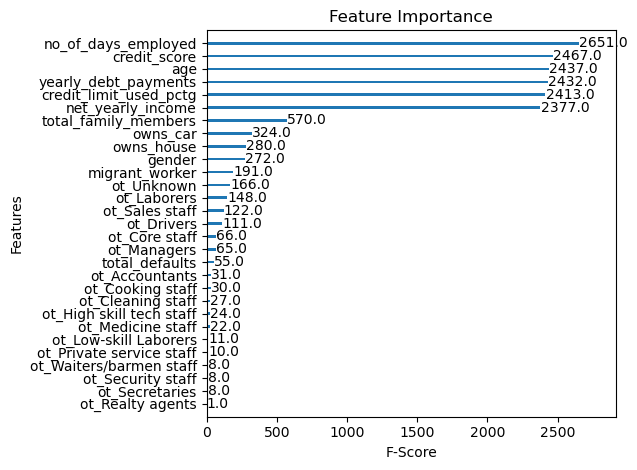

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 10))

# Plot feature importance
plot_importance(model, importance_type='weight', title='Feature Importance', xlabel='F-Score', ylabel='Features', grid=False)

# Show plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.savefig('../reports/figures/feature_importance.png')
plt.show()